# Monte-Carlo Version

We have two normal distributions $\phi_a=\phi(\mu_a,\sigma_a)$ and $\phi_b=\phi(\mu_b,\sigma_b)$ and simulate draws from the normal distributions.  We assume equal variance, so $\sigma_a=\sigma_b$.

In order to inspect the false-positive rate and the FWER, we set the "true" effect to zero.  In this case we know the null hypothesis is true.


In [36]:
import statsmodels.stats.power as smp
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# if using a Jupyter notebook, includue:
%matplotlib inline

In [51]:
# Set globals

alpha = 0.05 # the false positive rate
power = 0.80 # 1-false negative rate
sigma = 10.0  # standard deviation
mde = 0.10  # the relative minimum detectable effect
mu_a = 100.0
mu_b = mu_a*(1+mde)
d = (mu_b-mu_a)/sigma # standardized effect size
n_mc = 100  # monte-carlo trials

# do power calculation for number of observations required to detect minimum detectable effect
n_obs = math.ceil(smp.TTestIndPower().solve_power(effect_size = d, 
                                         power = power, 
                                         alpha = alpha))
n_obs

17

In [45]:

def monte_carlo(nsim, callback, *args, **kwargs):
	"""Run callback"""
	return(pd.DataFrame([callback(*args, **kwargs) for i in range(nsim)]))
    
def reject(n_obs=n_obs, mu_a=mu_a, mu_b=mu_b, sigma_a=sigma, sigma_b=sigma):
    v_a = sigma_a * np.random.randn(n_obs) + mu_a
    v_b = sigma_b * np.random.randn(n_obs) + mu_b

    ttr = scipy.stats.ttest_ind(v_a, v_b)
    return(ttr.pvalue < alpha)

In [46]:
# set the true effect to 0
effect = mde
mu_b = (1+effect)*mu_a

rej = monte_carlo(n_mc, reject, n_obs=n_obs, mu_a=mu_a, mu_b=mu_b, sigma_a=sigma, sigma_b=sigma)

# confirm the reject ratio is as expected
rej.mean()

0    0.84
dtype: float64

In [6]:
# Now define a function that returns the p-value
def p_value(n_obs=n_obs, mu_a=mu_a, mu_b=mu_b, sigma_a=sigma, sigma_b=sigma):
    v_a = sigma_a * np.random.randn(n_obs) + mu_a
    v_b = sigma_b * np.random.randn(n_obs) + mu_b

    ttr = scipy.stats.ttest_ind(v_a, v_b)
    return(ttr.pvalue)

# And a function that returns the test statistic
def tstatistic(n_obs=n_obs, mu_a=mu_a, mu_b=mu_b, sigma_a=sigma, sigma_b=sigma):
    v_a = sigma_a * np.random.randn(n_obs) + mu_a
    v_b = sigma_b * np.random.randn(n_obs) + mu_b

    ttr = scipy.stats.ttest_ind(v_a, v_b)
    return(ttr.statistic)


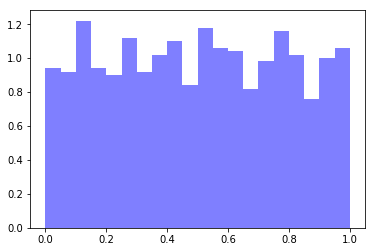

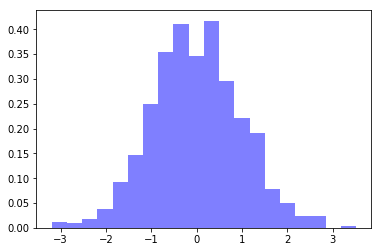

In [7]:
# Here we illustrate that if the null is true, the p-values are uniformly distributed
# between 0 and 1, and the t-statistics are normally distributed around 0

# set the true effect to 0
effect = 0
mu_b = (1+effect)*mu_a

# monte-carlo sample the p_values and t-statistics
pvs = monte_carlo(n_mc, p_value, n_obs=n_obs, mu_a=mu_a, mu_b=mu_b, sigma_a=sigma, sigma_b=sigma)
tss = monte_carlo(n_mc, tstatistic, n_obs=n_obs, mu_a=mu_a, mu_b=mu_b, sigma_a=sigma, sigma_b=sigma)

plt.hist(pvs[0], 20,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

plt.hist(tss[0], 20,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

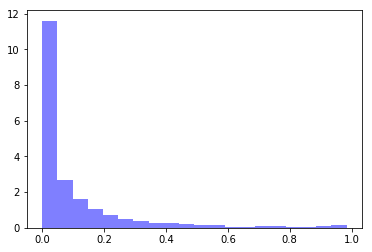

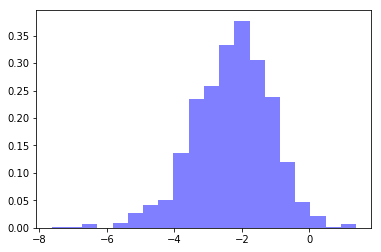

In [8]:
# In comparison we illustrate that if the null is false, the p-values are not uniformly 
# distributed between 0 and 1, and the t-statistics are not normally distributed around 0

# set the true effect to the mde
effect = mde
mu_b = (1+effect)*mu_a

pvs = monte_carlo(n_mc, p_value, n_obs=n_obs, mu_a=mu_a, mu_b=mu_b, sigma_a=sigma, sigma_b=sigma)
tss = monte_carlo(n_mc, tstatistic, n_obs=n_obs, mu_a=mu_a, mu_b=mu_b, sigma_a=sigma, sigma_b=sigma)

plt.hist(pvs[0], 20,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

plt.hist(tss[0], 20,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

# Joint-Distribution Version
Here we model the joint distribution as gaussian normal and then integrate over it.

In [2]:
import numpy as np
import pandas as pd
from scipy.special import ndtri,ndtr
from scipy.stats import multivariate_normal

corrs=['00']
#DIMS=[1,2,3,4,5,6,7,8,9,10]
DIMS=[1,2]

kappas=[0.0,1.5,3.0,0.0,1.5,3.0,0.0,1.5,3.0]
gammas=[0.5,0.5,0.5,1.0,1.0,1.0,3.0,3.0,3.0]

Np=10
pm=(np.linspace(1,Np,Np)-0.5)/Np # equally spaced p-values between (0,1)
Zm=ndtri(pm)  # Z-values for the p-values

print(pm)
print(Zm)

for ccorr in range(0,len(corrs)):
    label=corrs[ccorr]
    TF=pd.DataFrame()
    #TF['Zm']=Zm
    TF['pm']=pm
    
    TPR=pd.DataFrame()
    TPR['pm']=pm
    TPRone=pd.DataFrame()
    TPRone['pm']=pm
    
    DP=pd.DataFrame()
    DPone=pd.DataFrame()
    

    for cdim in range(0,len(DIMS)):
        print(ccorr,cdim)
        
        dim=DIMS[cdim]
        corr=float(corrs[ccorr])/100.0
        
        mean = np.zeros(dim)
        covar = corr*np.ones([dim,dim],float)
        np.fill_diagonal(covar,1.0)

        # We have defined mean=0, so the null is always True
        dist = multivariate_normal(mean=mean, cov=covar)

        Zrep=np.tile(Zm,(dim,1)).T # Z-values for the equally spaced p-values between 0 and 1
        TF[(corrs[ccorr],dim)]=dist.cdf(Zrep) # proportion of cases that don't reject the null, 
        TPR[(corrs[ccorr],dim)]=1.0-TF[(corrs[ccorr],dim)] # proportion of cases that do reject the null
        TPRone[(corrs[ccorr],dim)]=1.0-TF[(corrs[ccorr],dim)]

        # Null hypothesis: the mean of the t-statistics is zero, in 5% of cases reject that the mean is zero
        print(TPR)

        omp=np.append(np.append([0.0],TF[(corrs[ccorr],dim)].to_numpy()),[1.0])

        for ccorrp in range(0,len(corrs)):
            corrp=float(corrs[ccorrp])/100.0
            covarp = corrp*np.ones([dim,dim],float)
            np.fill_diagonal(covarp,1.0)
            distp = multivariate_normal(mean=mean, cov=covarp)
            
            for cs in range(0,len(kappas)):
                kap=kappas[cs]
                gam=gammas[cs]
                TPR[(corrs[ccorr],dim,corrs[ccorrp],kap,gam)]=1.0-distp.cdf(-kap+gam*Zrep)
                ttpr=np.append([1.0],np.append(TPR[(corrs[ccorr],dim,corrs[ccorrp],kap,gam)].to_numpy(),[0.0]))
                gini=2.0 * np.trapz( ttpr, x=omp ) - 1.0
#                 DP[(corrs[ccorr],dim,corrs[ccorrp],kap,gam)]=[gini]
# #                print(gini)
#                 Zrepcpy=Zrep.copy()
#                 Zrepcpy[:,0]=-kap+gam*Zrep[:,0]
#                 TPRone[(corrs[ccorr],dim,corrs[ccorrp],kap,gam)]=1.0-distp.cdf(Zrepcpy)
#                 ttpr=np.append([1.0],np.append(TPRone[(corrs[ccorr],dim,corrs[ccorrp],kap,gam)].to_numpy(),[0.0]))
#                 gini=2.0 * np.trapz( ttpr, x=omp ) - 1.0
#                 DPone[(corrs[ccorr],dim,corrs[ccorrp],kap,gam)]=[gini]

#     TF.to_csv('TF_'+label+'.csv')
#     TPR.to_csv('TPR_'+label+'.csv')
#     DP.transpose().to_csv('DP_'+label+'.csv')
#     TPRone.to_csv('TPRone_'+label+'.csv')
#     DPone.transpose().to_csv('DPone_'+label+'.csv')

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[-1.64485363 -1.03643339 -0.67448975 -0.38532047 -0.12566135  0.12566135
  0.38532047  0.67448975  1.03643339  1.64485363]
0 0
     pm  (00, 1)
0  0.05     0.95
1  0.15     0.85
2  0.25     0.75
3  0.35     0.65
4  0.45     0.55
5  0.55     0.45
6  0.65     0.35
7  0.75     0.25
8  0.85     0.15
9  0.95     0.05
[0.   0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.  ]
0 1
     pm  (00, 1)  (00, 2)
0  0.05     0.95   0.9975
1  0.15     0.85   0.9775
2  0.25     0.75   0.9375
3  0.35     0.65   0.8775
4  0.45     0.55   0.7975
5  0.55     0.45   0.6975
6  0.65     0.35   0.5775
7  0.75     0.25   0.4375
8  0.85     0.15   0.2775
9  0.95     0.05   0.0975
[0.     0.0025 0.0225 0.0625 0.1225 0.2025 0.3025 0.4225 0.5625 0.7225
 0.9025 1.    ]
